# Hybrid CF (Ideal case)

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error
from scipy.sparse.linalg import svds
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules
import math
from functools import reduce


In [2]:
# Sezione 1: Caricamento dati (MovieLens 100k)

url = "../datasets/ml-100k/u.data"
columns = ['user_id', 'movie_id', 'rating', 'timestamp']
df = pd.read_csv(url, sep='\t', names=columns)
df.drop(columns='timestamp', inplace=True)

print(df.head())

   user_id  movie_id  rating
0      196       242       3
1      186       302       3
2       22       377       1
3      244        51       2
4      166       346       1


In [3]:
# Sezione 2: Split train/test e train_matrix

train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

In [4]:
# Sezione 3: Controlli i casi di cold start per user e movie

# Estrai gli insiemi di ID
train_users = set(train_data['user_id'].unique())
test_users  = set(test_data ['user_id'].unique())

train_movies = set(train_data['movie_id'].unique())
test_movies  = set(test_data ['movie_id'].unique())

# Trova quelli “cold” (presenti in test ma non in train)
cold_users  = test_users  - train_users
cold_movies = test_movies - train_movies

print(f"Utenti in test NaN in train (cold users): {len(cold_users)}")  
print(cold_users)  # se vuoi la lista completa

print(f"Film in test NaN in train (cold items): {len(cold_movies)}")  
print(cold_movies)

Utenti in test NaN in train (cold users): 0
set()
Film in test NaN in train (cold items): 51
{1536, 1156, 1669, 1290, 907, 1546, 1674, 1675, 1551, 1677, 913, 1681, 1682, 1433, 1565, 1320, 1577, 1452, 1453, 814, 1583, 1201, 1587, 1460, 1596, 1599, 1600, 1601, 1603, 1476, 1349, 1352, 1611, 1614, 1619, 1364, 1493, 1494, 599, 1625, 1630, 1632, 1122, 1507, 1637, 1640, 1641, 1648, 1649, 1651, 1655}


In [5]:
# Sezione 3.1: Rimuovo i casi di cold start e creo la situazione ideale (Creo caso ideale)

# Filtra il test_data lasciando solo le righe “note” al train
test_data_clean = test_data[
    test_data['user_id'].isin(train_users) &
    test_data['movie_id'].isin(train_movies)
].copy()

# Verifico che non ci siano più cold-start
cold_users  = set(test_data_clean['user_id'])  - train_users
cold_movies = set(test_data_clean['movie_id']) - train_movies
assert len(cold_users)  == 0, "Ci sono ancora utenti cold-start!"
assert len(cold_movies) == 0, "Ci sono ancora film cold-start!"


In [6]:
# Sezione 4: Matrice utente-item e sparsità

train_rating_matrix_raw = train_data.pivot_table(index='user_id', columns='movie_id', values='rating')
test_rating_matrix = test_data.pivot_table(index='user_id', columns='movie_id', values='rating')
n_users, n_items = train_rating_matrix_raw.shape
nnz = train_rating_matrix_raw.count().sum()
sparsity = 1 - nnz / (n_users * n_items)
print(f"Numero utenti: {n_users}, Numero item: {n_items}")
print(f"Ratings non nulli: {nnz}")
print(f"Sparsità: {sparsity:.2%}")

# Trova film (colonne) che non sono mai stati votati nel train set
empty_movies = train_rating_matrix_raw.isna().all(axis=0)

# Conta quanti sono
print("Numero di film senza alcun voto nel train set:", empty_movies.sum())

# Trova user (righe) che non hanno mai votato nel train set
lazy_users = train_rating_matrix_raw.isna().all(axis=1)

# Conta quanti sono
print("Numero di utenti che non hanno votato nessun film:", lazy_users.sum())

Numero utenti: 943, Numero item: 1631
Ratings non nulli: 70000
Sparsità: 95.45%
Numero di film senza alcun voto nel train set: 0
Numero di utenti che non hanno votato nessun film: 0


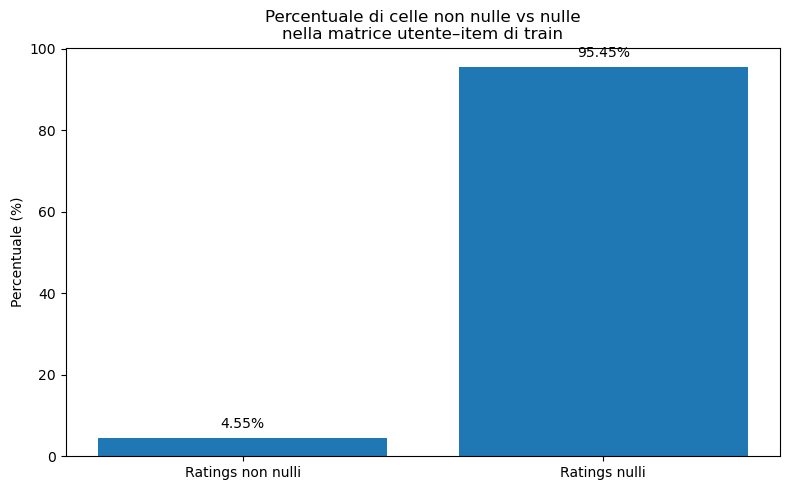

In [7]:
import matplotlib.pyplot as plt

# 1. Costruisci la matrice sparse
train_rating_matrix_raw = train_data.pivot_table(
    index='user_id', columns='movie_id', values='rating'
)

# 2. Calcola numeri assoluti e percentuali
n_users, n_items = train_rating_matrix_raw.shape
nnz = train_rating_matrix_raw.count().sum()
total = n_users * n_items
n_null = total - nnz

perc_non_null = nnz / total * 100
perc_null     = n_null / total * 100

# 3. Disegna il bar‐chart delle percentuali
labels = ['Ratings non nulli', 'Ratings nulli']
values = [perc_non_null, perc_null]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values)
plt.ylabel('Percentuale (%)')
plt.title('Percentuale di celle non nulle vs nulle\nnella matrice utente–item di train')

# Annotazioni con valori percentuali
for bar in bars:
    h = bar.get_height()
    plt.annotate(f'{h:.2f}%',
                 xy=(bar.get_x() + bar.get_width()/2, h),
                 xytext=(0, 5), textcoords='offset points',
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [8]:
# Sezione 5: Calcolo similarita: per gli utenti usiamo Pearson e per gli item usiamo cosine

# Centra la matrice per utenti (riga)
R_centered = train_rating_matrix_raw.sub(train_rating_matrix_raw.mean(axis=1), axis=0)
R_filled_user = R_centered.fillna(0)

# Similarità utenti con Pearson 
sim_pearson_u = 1 - pairwise_distances(R_filled_user, metric='correlation')
user_similarity = pd.DataFrame(sim_pearson_u,
                               index=train_rating_matrix_raw.index,
                               columns=train_rating_matrix_raw.index)

# Transponi la matrice (items come righe) e riempi i NaN con 0
R_filled_item = train_rating_matrix_raw.T.fillna(0)

# Calcola la similarità cosine sugli item
sim_cosine_i = cosine_similarity(R_filled_item)

# Ricostruisci in DataFrame con gli stessi indici/colonne
item_similarity = pd.DataFrame(sim_cosine_i,
                               index=train_rating_matrix_raw.columns,
                               columns=train_rating_matrix_raw.columns)


In [9]:
# Sezione 5.1: matrici di similarità

print("Similarità utenti (Pearson):")
print(user_similarity.head())

print("\nSimilarità item (Cosine):")
print(item_similarity.head())

Similarità utenti (Pearson):
user_id       1         2         3         4         5         6         7    \
user_id                                                                         
1        1.000000  0.025596 -0.011685  0.074057  0.051482  0.047608  0.106999   
2        0.025596  1.000000  0.008961  0.005184  0.018338  0.074488  0.043858   
3       -0.011685  0.008961  1.000000  0.051455  0.000000 -0.025470 -0.015642   
4        0.074057  0.005184  0.051455  1.000000 -0.004354 -0.047942 -0.002955   
5        0.051482  0.018338  0.000000 -0.004354  1.000000  0.013809  0.060387   

user_id       8         9         10   ...       934       935       936  \
user_id                                ...                                 
1        0.146086  0.006382 -0.036835  ...  0.026456 -0.040338  0.062600   
2        0.003289  0.048231 -0.011779  ... -0.008638  0.006990  0.038276   
3        0.017638 -0.005761  0.005342  ... -0.003087 -0.003481 -0.036075   
4        0.034466 -0.00

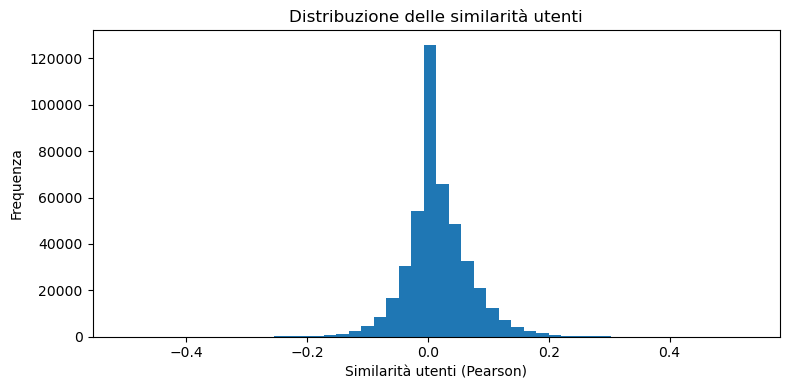

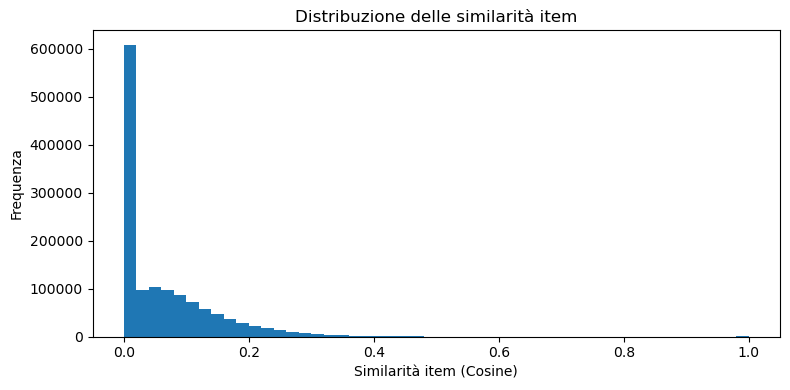

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Dopo aver calcolato user_similarity e item_similarity:
# (es. con il tuo codice già eseguito in precedenza)

# Estrai i valori escludendo la diagonale
us_vals = user_similarity.values[np.triu_indices_from(user_similarity, k=1)]
is_vals = item_similarity.values[np.triu_indices_from(item_similarity, k=1)]

# Rimuovi eventuali NaN
us_vals = us_vals[~np.isnan(us_vals)]
is_vals = is_vals[~np.isnan(is_vals)]

# Grafico per user-based similarity
plt.figure(figsize=(8, 4))
plt.hist(us_vals, bins=50)
plt.xlabel('Similarità utenti (Pearson)')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle similarità utenti')
plt.tight_layout()
plt.show()

# Grafico per item-based similarity
plt.figure(figsize=(8, 4))
plt.hist(is_vals, bins=50)
plt.xlabel('Similarità item (Cosine)')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle similarità item')
plt.tight_layout()
plt.show()


In [11]:
# Sezione 5.2: Cotrollo NaN in similarià

# Numero di NaN nella matrice di similarità utenti (Pearson)
num_nan_user = user_similarity.isna().sum().sum()
print(f"Numero di NaN in user_similarity: {num_nan_user}")

# Numero di NaN nella matrice di similarità item (Cosine)
num_nan_item = item_similarity.isna().sum().sum()
print(f"Numero di NaN in item_similarity: {num_nan_item}")


Numero di NaN in user_similarity: 0
Numero di NaN in item_similarity: 0


In [12]:
# Sezione 6: Calcolo predizione per user

# 1. Media dei voti per ogni utente 
user_means = train_rating_matrix_raw.replace(0, np.nan).mean(axis=1)

# 2. Scarti rispetto alla media 
user_centered = train_rating_matrix_raw.sub(user_means, axis=0).fillna(0)

# 3. Numeratore: somma pesata degli scarti 
numerator_user = user_similarity.dot(user_centered) 

# 4. Denominatore: somma dei valori assoluti delle similarità 
denominator_user = np.abs(user_similarity).sum(axis=1) 

# 5. Divisione e aggiunta della media 
P_user = numerator_user.div(denominator_user, axis=0).add(user_means, axis=0)


In [13]:
# Sezione 6.1: Calcolo predizione per item

# 2. Numeratore: somma pesata degli scarti 
numerator_item = user_centered.dot(item_similarity) 

# 3. Denominatore: somma dei valori assoluti
denominator_item = np.abs(item_similarity).sum(axis=1)  

# 4. Divisione e aggiunta della media 
P_item = numerator_item.div(denominator_item, axis=1).add(user_means, axis=0)


In [14]:
# Sezione 7: matrice ibrida con tuning sui pesi(alpha)

# Quanto pesare user-based vs item-based
alphas = np.arange(0, 1.1, 0.1)
hybrid_predictions = {}

for alpha in alphas:
    P_hybrid = alpha * P_user + (1 - alpha) * P_item
    hybrid_predictions[round(alpha, 2)] = P_hybrid

In [15]:
print(hybrid_predictions)

{0.0: movie_id      1         2         3         4         5         6     \
user_id                                                                
1         3.736224  3.712647  3.731159  3.738386  3.707964  3.778865   
2         3.904141  3.899276  3.898759  3.901267  3.898496  3.906960   
3         2.788633  2.790097  2.787795  2.789273  2.788358  2.788292   
4         4.496187  4.496094  4.496584  4.496399  4.496066  4.501237   
5         2.898034  2.879530  2.881789  2.884192  2.872006  2.881007   
...            ...       ...       ...       ...       ...       ...   
939       4.341390  4.337972  4.339831  4.338814  4.338557  4.337703   
940       3.489101  3.487831  3.482882  3.483343  3.484742  3.482780   
941       4.335437  4.333832  4.331832  4.333467  4.333078  4.336151   
942       4.320852  4.321308  4.318694  4.321581  4.317483  4.318969   
943       3.417944  3.426107  3.414544  3.423229  3.417544  3.412836   

movie_id      7         8         9         10    ...    

In [16]:
# Sezione 7.1: Controllo valore massimo e minimo delle predizioni

# Estrai tutti i valori delle matrici e concatenali in un array unico
all_values = np.concatenate([P.values.flatten() for P in hybrid_predictions.values()])

# Calcola minimo e massimo
global_min = all_values.min()
global_max = all_values.max()

print(f"Valore minimo tra tutte le predizioni: {global_min:.4f}")
print(f"Valore massimo tra tutte le predizioni: {global_max:.4f}")

Valore minimo tra tutte le predizioni: 1.3420
Valore massimo tra tutte le predizioni: 5.0787


In [17]:
# Sezione 7.2: Rendiamo i valori discreti

# Applica arrotondamento custom a ciascuna matrice nel dizionario
hybrid_predictions_rounded = {
    alpha: df.applymap(lambda x: 0 if x < 0.5 else 5 if x >= 5.5 else math.floor(x + 0.5))
    for alpha, df in hybrid_predictions.items()
}

# Estrai tutti i valori per trovare min e max globali
all_rounded_values = np.concatenate([df.values.flatten() for df in hybrid_predictions_rounded.values()])

print(f"Valore minimo (arrotondato): {all_rounded_values.min()}")
print(f"Valore massimo (arrotondato): {all_rounded_values.max()}")

C:\Users\aless\AppData\Local\Temp\ipykernel_15400\583786842.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  alpha: df.applymap(lambda x: 0 if x < 0.5 else 5 if x >= 5.5 else math.floor(x + 0.5))


Valore minimo (arrotondato): 1
Valore massimo (arrotondato): 5


In [18]:
# Sezione 8: Calcolo predizioni

# Lista per contenere i singoli DataFrame con colonne user_id, movie_id e predicted_rating_{alpha}
prediction_dfs = []

for alpha, P_rounded in hybrid_predictions_rounded.items():

    # Convertiamo in formato long
    df_long = P_rounded.reset_index().melt(
        id_vars='user_id',
        var_name='movie_id',
        value_name=f'predicted_rating_{alpha}'
    )
    
    prediction_dfs.append(df_long)

# Uniamo tutti i DataFrame sulle colonne user_id e movie_id
from functools import reduce

prediction_df = reduce(
    lambda left, right: pd.merge(left, right, on=['user_id', 'movie_id'], how='outer'),
    prediction_dfs
)

# Seleziona solo le colonne di interesse
subset_df = prediction_df[['user_id', 'movie_id', 'predicted_rating_1.0']]

# Visualizza le prime righe
print(subset_df.head())

   user_id movie_id  predicted_rating_1.0
0        1        1                     4
1        1        2                     4
2        1        3                     4
3        1        4                     4
4        1        5                     4


In [19]:
# Sezione 9: Calcolo metriche(MAE RMSE ACCURACY PRECISION RECALL)

# Lista dei threshold da valutare
thresholds = [3, 4]

# Lista per salvare risultati
results = []

# Per ogni colonna di predizione (es. predicted_rating_0.0, ..., predicted_rating_1.0)
for col in prediction_df.columns:
    if col.startswith('predicted_rating_'):

        alpha = col.split('_')[-1] 

        # Unisci test set con le predizioni per questo alpha
        valutazione_df = test_data_clean.merge(prediction_df[['user_id', 'movie_id', col]], 
                                               on=["user_id", "movie_id"], how="inner")
        valutazione_df = valutazione_df.rename(columns={col: "predicted_rating"})

        # Calcola RMSE e MAE
        rmse = np.sqrt(mean_squared_error(valutazione_df["rating"], valutazione_df["predicted_rating"]))
        mae = mean_absolute_error(valutazione_df["rating"], valutazione_df["predicted_rating"])

        # Per ogni threshold, calcola metriche binarie
        for threshold in thresholds:
            valutazione_df["true_label"] = (valutazione_df["rating"] >= threshold).astype(int)
            valutazione_df["predicted_label"] = (valutazione_df["predicted_rating"] >= threshold).astype(int)

            accuracy = accuracy_score(valutazione_df["true_label"], valutazione_df["predicted_label"])
            precision = precision_score(valutazione_df["true_label"], valutazione_df["predicted_label"], zero_division=0)
            recall = recall_score(valutazione_df["true_label"], valutazione_df["predicted_label"], zero_division=0)

            # Salva i risultati
            results.append({
                'alpha': float(alpha),
                'threshold': threshold,
                'rmse': rmse,
                'mae': mae,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall
            })

# Converti in DataFrame
valutazione_metrics_df = pd.DataFrame(results)

print(valutazione_metrics_df.head())

   alpha  threshold      rmse       mae  accuracy  precision    recall
0    0.0          3  1.080912  0.801102  0.835204   0.838181  0.992410
1    0.0          4  1.080912  0.801102  0.634636   0.663667  0.686657
2    0.1          3  1.078994  0.798831  0.835170   0.838175  0.992370
3    0.1          4  1.078994  0.798831  0.636774   0.665247  0.689499
4    0.2          3  1.077120  0.797061  0.835170   0.838175  0.992370


In [20]:
# Sezione 8.1: Combinazione migliore per le  metriche

# Combinazione che minimizza RMSE
best_rmse = valutazione_metrics_df.loc[valutazione_metrics_df['rmse'].idxmin()]

# Combinazione che minimizza MAE
best_mae = valutazione_metrics_df.loc[valutazione_metrics_df['mae'].idxmin()]

# Combinazione che massimizza Precision
best_precision = valutazione_metrics_df.loc[valutazione_metrics_df['precision'].idxmax()]

# Combinazione che massimizza Recall
best_recall = valutazione_metrics_df.loc[valutazione_metrics_df['recall'].idxmax()]

# Combinazione che massimizza Accuracy
best_accuracy = valutazione_metrics_df.loc[valutazione_metrics_df['accuracy'].idxmax()]

best_combinations = pd.DataFrame([
    {'metric': 'RMSE minimo', 'alpha': best_rmse['alpha'], 'threshold': best_rmse['threshold'],
     'rmse': best_rmse['rmse'], 'mae': best_rmse['mae'],
     'precision': best_rmse['precision'], 'recall': best_rmse['recall'], 'accuracy': best_rmse['accuracy']},

    {'metric': 'MAE minimo', 'alpha': best_mae['alpha'], 'threshold': best_mae['threshold'],
     'rmse': best_mae['rmse'], 'mae': best_mae['mae'],
     'precision': best_mae['precision'], 'recall': best_mae['recall'], 'accuracy': best_mae['accuracy']},

    {'metric': 'Precisione massima', 'alpha': best_precision['alpha'], 'threshold': best_precision['threshold'],
     'rmse': best_precision['rmse'], 'mae': best_precision['mae'],
     'precision': best_precision['precision'], 'recall': best_precision['recall'], 'accuracy': best_precision['accuracy']},

    {'metric': 'Recall massimo', 'alpha': best_recall['alpha'], 'threshold': best_recall['threshold'],
     'rmse': best_recall['rmse'], 'mae': best_recall['mae'],
     'precision': best_recall['precision'], 'recall': best_recall['recall'], 'accuracy': best_recall['accuracy']},

    {'metric': 'Accuracy massima', 'alpha': best_accuracy['alpha'], 'threshold': best_accuracy['threshold'],
     'rmse': best_accuracy['rmse'], 'mae': best_accuracy['mae'],
     'precision': best_accuracy['precision'], 'recall': best_accuracy['recall'], 'accuracy': best_accuracy['accuracy']}
])

# Mostra con valori arrotondati
print(best_combinations.round(4))


               metric  alpha  threshold    rmse     mae  precision  recall  \
0         RMSE minimo    1.0        3.0  1.0650  0.7855     0.8383  0.9924   
1          MAE minimo    1.0        3.0  1.0650  0.7855     0.8383  0.9924   
2  Precisione massima    0.9        3.0  1.0665  0.7868     0.8383  0.9925   
3      Recall massimo    0.9        3.0  1.0665  0.7868     0.8383  0.9925   
4    Accuracy massima    0.9        3.0  1.0665  0.7868     0.8383  0.9925   

   accuracy  
0    0.8354  
1    0.8354  
2    0.8354  
3    0.8354  
4    0.8354  


In [21]:
# Sezione 10: Funzione per il calcolo metriche TopK (RECALL@K PRECISION@K MAP@K)

def precision_recall_ap_at_k(df, k=5, rel_threshold=4):
    metrics = []

    for user_id, group in df.groupby('user_id'):
        # Ordinare per predicted_rating decrescente
        group_sorted = group.sort_values('predicted_rating', ascending=False)

        # Rilevanti reali (ground truth)
        relevant_items = set(group[group['rating'] >= rel_threshold]['movie_id'])

        # Top-k raccomandati
        recommended = group_sorted.head(k)
        recommended_ids = list(recommended['movie_id'])

        # Precision@k
        rel_k = [1 if movie in relevant_items else 0 for movie in recommended_ids]
        precision_at_k = sum(rel_k) / k

        # Recall@k
        recall_at_k = sum(rel_k) / len(relevant_items) if relevant_items else 0.0

        # Average Precision@k (AP@k)
        num_hits = 0
        sum_precisions = 0.0
        for i, hit in enumerate(rel_k):
            if hit:
                num_hits += 1
                sum_precisions += num_hits / (i + 1)
        ap_at_k = sum_precisions / len(relevant_items) if relevant_items else 0.0

        metrics.append({
            'user_id': user_id,
            'precision@k': precision_at_k,
            'recall@k': recall_at_k,
            'ap@k': ap_at_k
        })

    # Costruire un DataFrame dei risultati per utente
    results = pd.DataFrame(metrics)
     
    # Calcolare MAP@k (media degli AP@k)
    map_at_k = results['ap@k'].mean()

    return results, map_at_k

In [22]:
# Sezione 10.1: Calcolo metriche TopK (RECALL@K PRECISION@K MAP@K) con tuning su Treshold e K

thresholds = [3, 4]  
ks = [5, 10, 15, 20]  

topn_results = []

for col in prediction_df.columns:
    if col.startswith('predicted_rating_'):
        alpha = float(col.split('_')[-1])  

        for threshold in thresholds:
            # Crea DataFrame con rating reale + predizione corrente
            df_eval = test_data_clean.merge(
                prediction_df[['user_id', 'movie_id', col]],
                on=['user_id', 'movie_id'],
                how='inner'
            ).rename(columns={col: 'predicted_rating'})

            for k in ks:
                # Calcola le metriche Top-N per ogni k
                topn_metrics, map_at_k = precision_recall_ap_at_k(
                    df_eval,
                    k=k,
                    rel_threshold=threshold
                )

                # Salva le metriche aggregate
                topn_results.append({
                    'alpha': alpha,
                    'threshold': threshold,
                    'k': k,
                    'precision': topn_metrics['precision@k'].mean(),
                    'recall': topn_metrics['recall@k'].mean(),
                    'map': map_at_k
                })


In [23]:
# Sezione 10.3: Visualizzazione etriche per alpha a 1 (User based)

topn_metrics_df = pd.DataFrame(topn_results).sort_values(by=['alpha', 'threshold', 'k'])

# Filtra il DataFrame per alpha == 1
alpha_1_df = topn_metrics_df[topn_metrics_df['alpha'] == 1.0]

# Visualizza le righe filtrate
print(alpha_1_df)


    alpha  threshold   k  precision    recall       map
80    1.0          3   5   0.840721  0.343527  0.309895
81    1.0          3  10   0.778579  0.559392  0.495836
82    1.0          3  15   0.704984  0.671755  0.592020
83    1.0          3  20   0.642259  0.744874  0.654622
84    1.0          4   5   0.591092  0.343229  0.259634
85    1.0          4  10   0.546766  0.560051  0.395465
86    1.0          4  15   0.492966  0.672596  0.465803
87    1.0          4  20   0.447296  0.744738  0.509927


In [24]:
# Sezione 10.3: Visualizzazione etriche per alpha a 0.5 

# Filtra il DataFrame per alpha == 0.5
alpha_0_5_df = topn_metrics_df[topn_metrics_df['alpha'] == 0.5]

# Visualizza le righe filtrate
print(alpha_1_df)

    alpha  threshold   k  precision    recall       map
80    1.0          3   5   0.840721  0.343527  0.309895
81    1.0          3  10   0.778579  0.559392  0.495836
82    1.0          3  15   0.704984  0.671755  0.592020
83    1.0          3  20   0.642259  0.744874  0.654622
84    1.0          4   5   0.591092  0.343229  0.259634
85    1.0          4  10   0.546766  0.560051  0.395465
86    1.0          4  15   0.492966  0.672596  0.465803
87    1.0          4  20   0.447296  0.744738  0.509927


In [25]:
# Sezione 10.4: Visualizzazione etriche per alpha a 0 (Item based)

# Filtra il DataFrame per alpha == 1
alpha_0_df = topn_metrics_df[topn_metrics_df['alpha'] == 0.0]

# Visualizza le righe filtrate
print(alpha_1_df)


    alpha  threshold   k  precision    recall       map
80    1.0          3   5   0.840721  0.343527  0.309895
81    1.0          3  10   0.778579  0.559392  0.495836
82    1.0          3  15   0.704984  0.671755  0.592020
83    1.0          3  20   0.642259  0.744874  0.654622
84    1.0          4   5   0.591092  0.343229  0.259634
85    1.0          4  10   0.546766  0.560051  0.395465
86    1.0          4  15   0.492966  0.672596  0.465803
87    1.0          4  20   0.447296  0.744738  0.509927


In [26]:
# Sezione 10.4: Combinazione migliore per metriche Top@K

# Trova le righe con le metriche migliori su tutti i k
best_precision_row = topn_metrics_df.loc[topn_metrics_df['precision'].idxmax()]
best_recall_row    = topn_metrics_df.loc[topn_metrics_df['recall'].idxmax()]
best_map_row       = topn_metrics_df.loc[topn_metrics_df['map'].idxmax()]

# Crea un DataFrame riepilogativo
best_topk_combinations = pd.DataFrame([
    {
        'metric': 'Precision massima',
        'alpha': best_precision_row['alpha'],
        'threshold': best_precision_row['threshold'],
        'k': best_precision_row['k'],
        'precision': best_precision_row['precision'],
        'recall': best_precision_row['recall'],
        'map': best_precision_row['map']
    },
    {
        'metric': 'Recall massima',
        'alpha': best_recall_row['alpha'],
        'threshold': best_recall_row['threshold'],
        'k': best_recall_row['k'],
        'precision': best_recall_row['precision'],
        'recall': best_recall_row['recall'],
        'map': best_recall_row['map']
    },
    {
        'metric': 'MAP massima',
        'alpha': best_map_row['alpha'],
        'threshold': best_map_row['threshold'],
        'k': best_map_row['k'],
        'precision': best_map_row['precision'],
        'recall': best_map_row['recall'],
        'map': best_map_row['map']
    }
])

# Mostra il DataFrame con valori arrotondati
best_topk_combinations.round(4)


,metric,alpha,threshold,k,precision,recall,map
0,Precision massima,1.0,3.0,5.0,0.8407,0.3435,0.3099
1,Recall massima,0.9,3.0,20.0,0.6424,0.7449,0.6543
2,MAP massima,1.0,3.0,20.0,0.6423,0.7449,0.6546


In [28]:
# Sezione 10.5: Visualizzazione grafica della metrica MAP@K

import plotly.express as px 

# Filtra per un threshold specifico
threshold = 3
df_thr = topn_metrics_df[topn_metrics_df['threshold'] == threshold]

fig = px.scatter_3d(df_thr, 
                    x='alpha', y='k', z='map',
                    color='map',
                    title='',
                    labels={'alpha':'Alpha', 'k':'Top-K', 'map':'MAP'},
                    color_continuous_scale='Viridis')

fig.show()
